In [13]:
import awswrangler as wr

def get_symbols():
    # S&P 500
    df = wr.s3.read_csv("s3://faysal/stocks/symbols/sp500.csv")
    symbols = list(df["Symbol"].values)
    # S&P 400 MidCaps
    df = wr.s3.read_csv("s3://faysal/stocks/symbols/sp400.csv")
    symbols.extend(df["Symbol"].values)
    # S&P 600 SmallCaps
    df = wr.s3.read_csv("s3://faysal/stocks/symbols/sp600.csv")
    symbols.extend(df["Symbol"].values)

    return [s.upper() for s in symbols if isinstance(s, str)]

symbols = get_symbols()

In [27]:
from OutsideWorld.Investing.Screener import Screener, ScreeningCriteria, ScreeningResult

screener = Screener()
criteria: ScreeningCriteria = ScreeningCriteria(
    country = "US",
    min_market_cap = 250000000,
    min_volume = None,
    min_dividend = None,
    max_beta = None,
    is_etf = False,
    is_actively_trading = True
)

symbols: ScreeningResult = screener.screen(criteria=criteria)

screened_symbols = [s.symbol for s in symbols]
screened_symbols = [s.split(".")[0] for s in screened_symbols]
screened_symbols = [s for s in screened_symbols if len(s) < 5 and "0" not in s]
screened_symbols = list(set(screened_symbols))


In [ ]:
#todo:
# kill BDCs, Reits, closed-end, pharma < 30B, banks, insurance
# compare to peers, sector/industry
# kill negative eps
# kill gambling, "industry": "Entertainment",  Gambling
# add growth in net margin
# add commondities prices (oil) to the summary
#qoq calc for oe look wrong?
# add net margin increase


In [25]:
import pickle
rejects = []

with open("../data/existing_matches.pickle", "wb") as f:
    pickle.dump(rejects, f)

This feeds a rolling list which another app montiors
2nd app looks for the first trading day with a significant positive gain, that's the buy trigger.
Expires after 40 trading days.
2nd app keeps list of triggers, 1st app won't retrigger until expired. 

have to define what a good entry looks like when undervalued is detected.  see VSH.

In [183]:
with open("../data/existing_matches.pickle", "rb") as f:
    existing_matches = pickle.load(f)

[x for x in existing_matches]


EOFError: Ran out of input

In [29]:
matches = []
from fetch_data import fetch_data
import numpy as np
import datetime
import pickle 

start_dt = datetime.datetime.today() - datetime.timedelta(weeks=78)

for s in screened_symbols:
    try:
        #df = fetch_data(s, start_dt.isoformat()[0:10])
        with open(f"../data/dfs/{s}.pickle", "rb") as f:
            df = pickle.load(f)
        
        col = "ratio_pe"
        df["stdevs"] = (df[col] - np.mean(df[col])) / np.std(df[col])

        # persist
        with open(f"../data/dfs/{s}.pickle", "wb") as f:
            pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

        test_day = df.iloc[-1]
    except Exception as e:
        continue

    if  test_day["atoi_lag_1"] > 0 and \
        test_day["atoi"] > 0 and \
        test_day["atoi_qoq_growth"] > -0.05 and \
        test_day["owners_earnings_lag_1"] > 0 and \
        test_day["owners_earnings"] > 0 and \
        test_day["owners_earnings_qoq_growth"] > 0.08 and \
        test_day["net_margin"] > 0.05 and \
        test_day["net_margin_growth"] > 0 and \
        test_day["net_margin_growth_lag_1"] > 0 and \
        test_day["roic"] > 0.15 and \
        test_day["totalStockholdersEquity"] > 0 and \
        test_day["stdevs"] < -0.51 and \
        test_day["ratio_peg"] < 0.5:
        

        # match found
        today = df.iloc[-1]
        gain = round(( today["marketCap"] - test_day["marketCap"] ) / test_day["marketCap"] * 100, 2)

        print(f"{s}: {test_day.name} to {today.name} gain: {gain} | \t peg: {test_day['ratio_peg']} \t {test_day['net_margin_growth_lag_1']}")
        # print(s)
        # matches.append(s)

ABNB: 2024-01-24 00:00:00 to 2024-01-24 00:00:00 gain: 0.0 | 	 peg: 0.16550765129642617 	 1.247080826850369
FTDR: 2024-01-24 00:00:00 to 2024-01-24 00:00:00 gain: 0.0 | 	 peg: 0.15635894736842107 	 0.3157156725272355
NE: 2024-01-24 00:00:00 to 2024-01-24 00:00:00 gain: 0.0 | 	 peg: 0.13457672252142716 	 0.15629838218017164
WNC: 2024-01-24 00:00:00 to 2024-01-24 00:00:00 gain: 0.0 | 	 peg: 0.053248719903835805 	 0.1032282943639942
AGCO: 2024-01-24 00:00:00 to 2024-01-24 00:00:00 gain: 0.0 | 	 peg: 0.07851362494586402 	 0.014420426597111825
GOGO: 2024-01-24 00:00:00 to 2024-01-24 00:00:00 gain: 0.0 | 	 peg: 0.07336688905533072 	 0.022808868955311108
CBT: 2024-01-24 00:00:00 to 2024-01-24 00:00:00 gain: 0.0 | 	 peg: 0.08344782045454545 	 0.4724317049753408
MSI: 2024-01-24 00:00:00 to 2024-01-24 00:00:00 gain: 0.0 | 	 peg: 0.32065579964850616 	 0.10068612469988808
IEX: 2024-01-24 00:00:00 to 2024-01-24 00:00:00 gain: 0.0 | 	 peg: 0.2519061072412117 	 0.061382492152414515
TNC: 2024-01-24 00

In [100]:
with open("../data/dfs/HWM.pickle", "rb") as f:
    chdn = pickle.load(f)

print(chdn.iloc[-1].to_string())

symbol                                       HWM
marketCap                            22771240000
operatingCashFlow                    898000000.0
freeCashFlow                         689000000.0
debtRepayment                       -385000000.0
commonStockRepurchased              -215000000.0
dividendsPaid                        -69000000.0
depreciationAndAmortization          271000000.0
capitalExpenditure                  -209000000.0
changeInWorkingCapital              -247000000.0
netIncome                            640000000.0
reinvestment                         185000000.0
owners_earnings                      455000000.0
owners_earnings_lag_1                388000000.0
owners_earnings_lag_2                309000000.0
owners_earnings_qoq_growth               0.17268
owners_earnings_qoq_growth_lag_1        0.255663
net_income_lag_1                     532000000.0
net_income_lag_2                     486000000.0
cashAndCashEquivalents                 424000000
totalAssets         

In [103]:
print(chdn.iloc[-2].to_string())

symbol                                       HWM
marketCap                            23212080000
operatingCashFlow                    898000000.0
freeCashFlow                         689000000.0
debtRepayment                       -385000000.0
commonStockRepurchased              -215000000.0
dividendsPaid                        -69000000.0
depreciationAndAmortization          271000000.0
capitalExpenditure                  -209000000.0
changeInWorkingCapital              -247000000.0
netIncome                            640000000.0
reinvestment                         185000000.0
owners_earnings                      455000000.0
owners_earnings_lag_1                388000000.0
owners_earnings_lag_2                309000000.0
owners_earnings_qoq_growth               0.17268
owners_earnings_qoq_growth_lag_1        0.255663
net_income_lag_1                     532000000.0
net_income_lag_2                     486000000.0
cashAndCashEquivalents                 424000000
totalAssets         

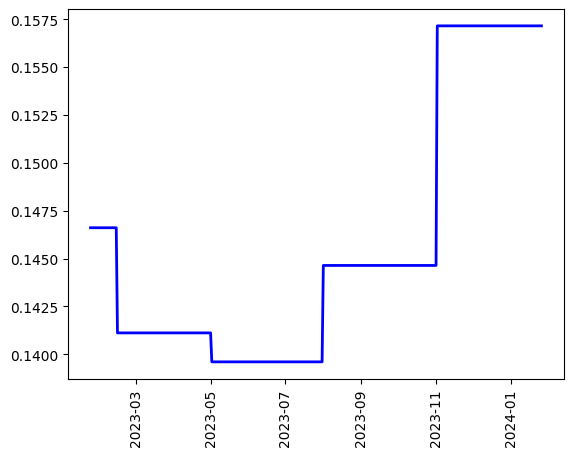

In [77]:
from fetch_data import fetch_data

df = fetch_data("HWM", "2023-01-23")



import matplotlib.pyplot as plt

x = df.index
y = df["roic"]

plt.plot(x,y, color="blue", linewidth=2, markersize=4, label = "P/S")
plt.xticks(rotation=90)
plt.show()



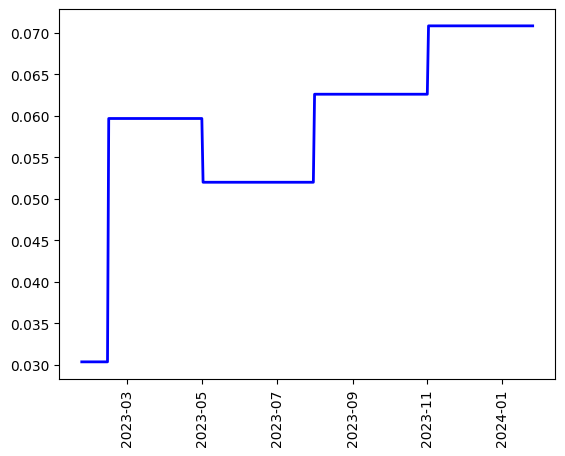

In [78]:
y = df["oe_margin"]

plt.plot(x,y, color="blue", linewidth=2, markersize=4, label = "P/E")
plt.xticks(rotation=90)
plt.show()

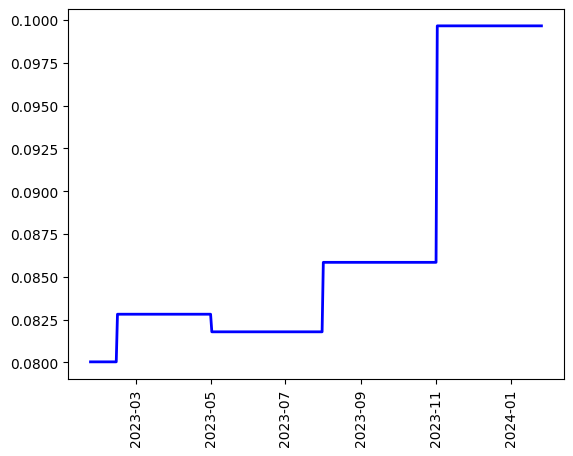

In [79]:
y = df["net_margin"]

plt.plot(x,y, color="blue", linewidth=2, markersize=4, label = "P/E")
plt.xticks(rotation=90)
plt.show()

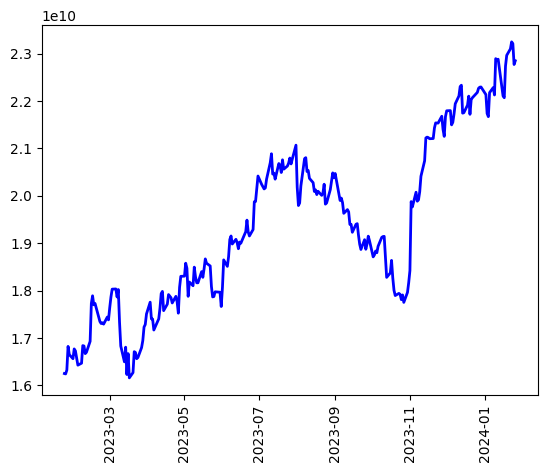

In [80]:
y = df["marketCap"]

plt.plot(x,y, color="blue", linewidth=2, markersize=4, label = "P/E")
plt.xticks(rotation=90)
plt.show()

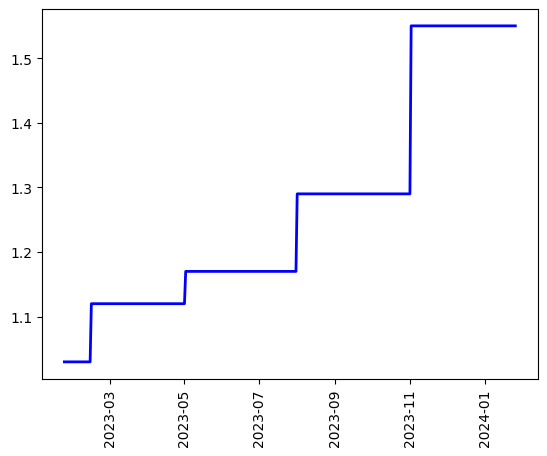

In [81]:
plt.plot(x,df["eps"], color="blue", linewidth=2, markersize=4, label = "P")
plt.xticks(rotation=90)
plt.show()

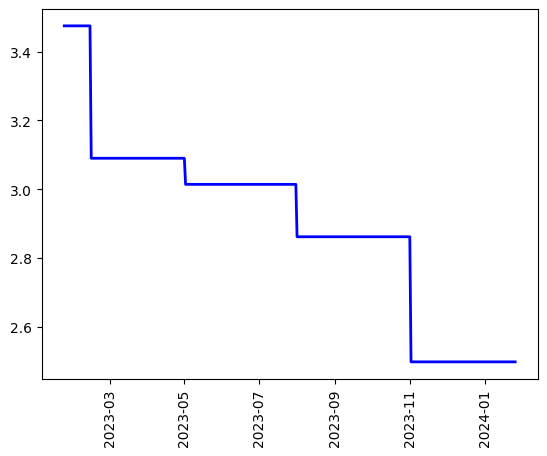

In [82]:

plt.plot(x,df["ratio_netDebt_to_ebitda"], color="blue", linewidth=2, markersize=4, label = "P")
plt.xticks(rotation=90)
plt.show()


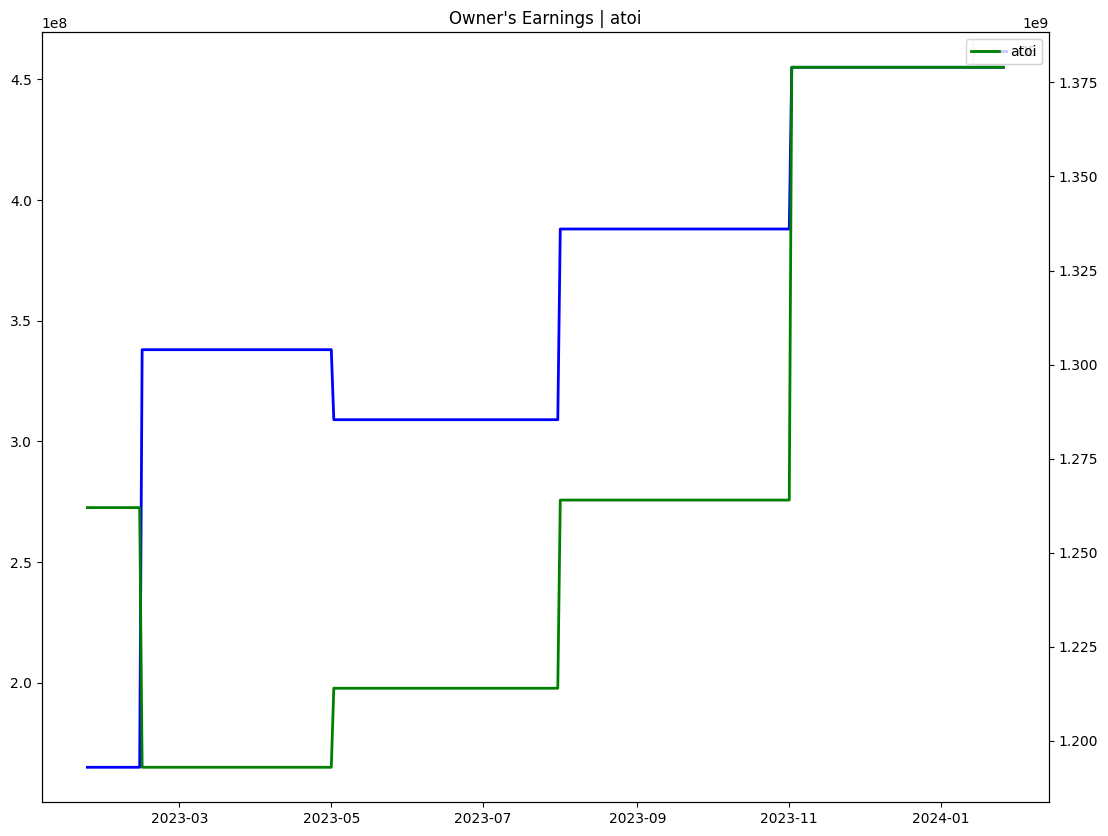

In [99]:
plt.figure(figsize=(13, 10))  
plt.plot(x,df["owners_earnings"], color="blue", linewidth=2, markersize=4, label = "OE")
plt.legend()
plt.twinx()
plt.plot(x,df["atoi"], color="green", linewidth=2, markersize=4, label = "atoi")
plt.legend()
plt.xticks(rotation=90)
plt.title("Owner's Earnings | atoi")

plt.show()

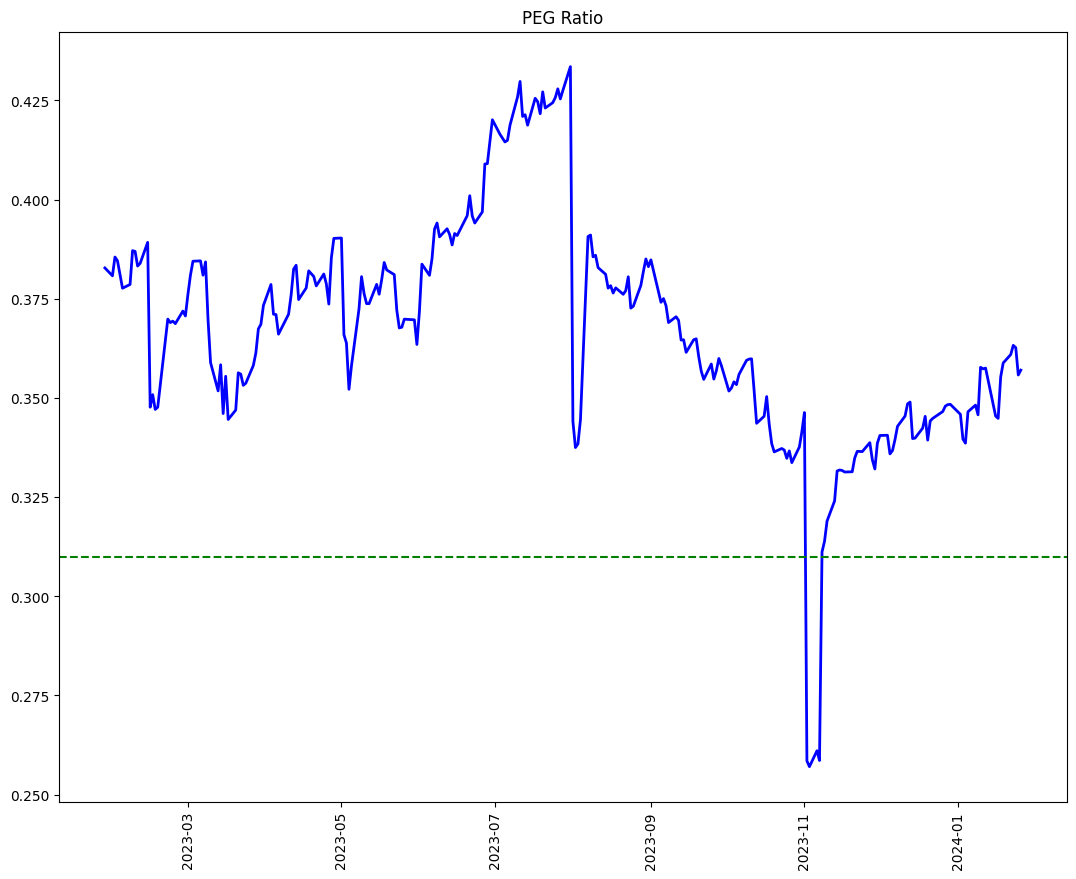

In [94]:
plt.figure(figsize=(13, 10))  
plt.plot(x,df["ratio_peg"], color="blue", linewidth=2, markersize=4, label = "P")
plt.xticks(rotation=90)
plt.title("PEG Ratio")
plt.axhline(y=(df["ratio_peg"].mean() - 2*df["ratio_peg"].std()), color="green", linestyle="--")
plt.show()

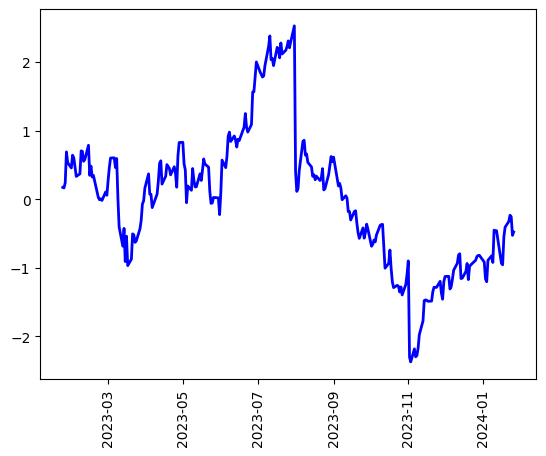

In [85]:
import numpy as np

#a = (np.mean(df["ratio_pe"]), np.stdev(df["ratio_pe"]))

col = "ratio_pe"
df["stdevs"] = (df[col] - np.mean(df[col])) / np.std(df[col])
# df["net_margin_lag_1"] = df["net_margin"].shift(1)
# df["net_margin_qoq_growth"] = (df["net_margin"] - df["net_margin_lag_1"]) / df["net_margin_lag_1"]

plt.plot(x,df["stdevs"], color="blue", linewidth=2, markersize=4, label = "P")
plt.xticks(rotation=90)
plt.show()

In [86]:
print("Operator: Good day ladies and gentlemen and welcome to the Consensus Q3 2023 Earnings Call. My name is Paul and I will be the operator assisting you today. At this time, all participants are in a listen-only mode. A question-and-answer session will follow the formal presentation. [Operator Instructions] On this call from Consensus will be Scott Turicchi, CEO; John Nebergall, COO; Jim Malone, CFO; and Adam Varon, Senior Vice President of Finance. I will now turn the call over to Adam Varon Senior Vice President of Finance at Consensus. Thank you. You may begin.\nAdam Varon: Good afternoon and welcome to the Consensus investor call to discuss our Q3 2023 financial results, other key information, and 2023 guidance. Joining me today are Scott Turicchi, CEO; John Nebergall, COO; and Jim Malone, CFO. The earnings call will begin with Scott providing opening remarks, John will give you an update on our operational progress since our Q2 investor call, and then Jim will discuss the Q3 2023 financial results and 2023 guidance. After we finish our prepared remarks, we will conduct a Q&A session. At that time, the operator will instruct you on the procedures for asking your question. Before we begin our prepared remarks, allow me to direct you to the Safe Harbor language on Slide 2. As you know this call and the webcast will include forward-looking statements. Such statements may involve risks and uncertainties that would cause actual results to differ materially from the anticipated results. Some of those risks and uncertainties include but are not limited to the risk factors outlined on Slide 3 that we have disclosed in our 10-K SEC filing as well as a summary of those risk factors that we have included as part of the slide show for the webcast. We refer you to discussions in those documents regarding Safe Harbor language as well as forward-looking statements. Now, let me turn the call over to Scott.\nScott Turicchi: Thank you, Adam. It's now been two years since our spin, I would like to make some brief comments as we look back over these past two years. As you know we spun with a go-to-market focus and product roadmap aimed at the healthcare sector. We have made substantial investments and strides in this space with more than half of our corporate revenue now coming from the healthcare sector. However, we have also seen inflation and a tight labor market impact revenue growth in this piece of our business. In fact in the past two quarters, we have seen overall corporate revenue growth of approximately 3%, down from approximately 13% in Q3 of 2022. This was driven by a slowdown in revenue generation from our healthcare customers due to stable usage slower, sign-ups, and a slow ramp of our larger customers. Until there is a substantial relief in the labor markets, we expect these trends to continue. As we look to next year with continuing uncertainty in both the economy as well as the labor markets, we'll be focusing our attention on EBITDA and free cash flow generation. As a result, we will reduce our capitalized investments from the level of the past two years while still investing in the business at a rate higher than prior to the spin. The record cash balances of $156 million in future free cash flow will be dedicated to repurchasing our equity and debt securities. Now, that we have cleared the two-year mark from the spin, we are able to repurchase debt and as a result the Board has authorized a $300 million repurchase program over the next three years. This program covers both the 6% notes that mature in October of 2026 as well as the 6.5% notes due in October of 2028. These repurchases can take a variety of forms and we'll be opportunistic similar in manner to our existing stock repurchase program. While we are early in the budgeting process, I would expect negligible overall revenue growth in 2024, with continuing decline in SoHo revenues offset by mid-single-digit growth in our Corporate channel. I would also expect greater growth in our EBITDA than in our revenue. We will be providing full-year 2024 guidance on our Q4 earnings call to be held in February. While our revenues were disappointing in the quarter there were several factors that affected the results. Within the SoHo channel, we cut a meaningful amount of marketing spend on questionable profitability channels. I would also note that as we discussed last quarter the price change to that base is complete. On the Corporate side, in addition to the headwinds experienced in the healthcare sector, we also completed the migration of our FAXBOX customer base, but did incur customer attrition in the process. This was a legacy system that needed to be retired notwithstanding the customer and revenue loss. On the bright side, our EBITDA margin remained strong at 52.5% the midpoint of our range. And coupled with interest income on our cash balances and a lower share count, produced year-over-year growth in EPS. In addition, we generated a record $50 million of free cash flow for a full fiscal quarter post spin and more importantly $83 million for the nine months. As usual, there are timing differences in payment of estimated taxes and cash collections of receivables. Also as we've noted before, due to our debt structure and interest payments, we generate most of our free cash flow in quarters one and three. I will now turn the call over to John for more detail on the quarter.\nJohn Nebergall: Hi, thank you, Scott. As we mentioned on the last call, we held a meeting with the ECFax partners to discuss tactics for accelerating the rollout. The talks were substantive and all partners agreed that an acceleration of the overall program in 2024 would be a mutual goal. In that context, we are actively working on acceleration options and are making progress on the overall plan. While not final, we are encouraged by the direction and anticipate a favorable schedule for next year. Now that said, we have seen the hurdles that can be encountered in a project of this scope and are going to be cautious in forecasting any revenue expected from the program next year. As for the current state of the implementation, we have increased the numbers of facilities using ECFax. And while the pure number of facilities is an improvement, the level of usage per facility varies and not every location has been fully implemented. As we have discussed, there are nearly 30 other government agencies in the pipeline and while progress is being made the threat of a government shutdown earlier this quarter and the upcoming holiday season have slowed the speed of discussions. We do not expect any measurable progress on this front, until sometime in 2024. On the Clarity front, we are in the process of implementing our first Clarity PA client, who signed last July. Clarity PA is a specifically engineered version of Clarity, aimed at the problem of prior authorization workflow. As Scott has mentioned, the slow progress in both closing the deal and implementing the customers are fully on display here. The deal took 15 months to close and will likely require an additional 12 months to implement. In the AI market, this is a typical time frame and is what we can anticipate with each subsequent prospect engagement. Separately, we have launched the Clarity CD product, tuned for Clinical Documentation Administration and build the pipeline of interest. Our sales team is progressing through those opportunities and serious discussions are underway. On the sales front for the quarter, Q3 bookings came in at $6.4 million, which was a welcome improvement from both Q1 and Q2 results. Historically, Q3 has been the best month seasonally for sales and it appears to be holding true this year. While this result is a welcome improvement sequentially, it is still under last year's Q3 result and year-to-date overall 2023 bookings are still lagging 20% behind our 2022 pace. Our advanced product sales came in just short of $1 million and while that was an improvement over Q2, that also still lags behind the 2022 pace. We've also continued our aggressive pursuit of harvesting healthcare accounts from the SoHo base into a more expensive corporate product. For the past several quarters, we have been successfully upgrading more than 1,000 SoHo accounts per quarter, into a corporate product and this quarter is no exception with about 1,300 customers upgraded from SoHo. While each upgrade is a positive increase in revenue, it does come with a negative impact in a couple of key metrics that are important to note. First, these customers tend to be on the extreme low end of our corporate average revenue per account or ARPA range, impacting our overall corporate ARPA with downward pressure. Second, the process for changing an account from SoHo to corporate includes, cancellation of the SoHo account. This process then creates an unfavorable impact on SoHo churn, as our system calculates the cancellation as a churned account. So as you assess our operating metrics, be aware that our upgrade program has those impacts. In the quarter, we were able to close two large hospital system deals, with a combined 60-plus hospitals over 400 clinics and more than 100 skilled nursing facilities. Due to their level of complexity, we anticipate that implementation will take most if not all of 2024. As you will recall from our discussion about the go-to-market realignment earlier this year, we established the e-commerce group for all web-based self-service sales. This group includes our traditional SOHO revenue stream and has been expanded to encompass upmarket sales to the SMB market. This quarter, the SOHO market saw a further moderation of the churn that we saw last year due to our price increase rollout. Churn for the quarter came in just under 3.5%, a nice improvement from last year's Q3 result. Now as mentioned earlier that number includes the 1,300 accounts that we upgraded to Corporate. As we discussed last call, we continue to see the pace of new adds fall under pre-pandemic levels. As we've also said on our last call, the expectation is that this trend will be the new normal in SOHO as we have made the decision to pull back spending in areas of SOHO that we found to have questionable profitability and we'll continue to scrutinize our marketing spend to ensure high returns for the business. This quarter we launched an e-commerce product targeting SMB customers. Traditionally we had used our inside sales team to sell inbound web opportunities and these form-fill customers would be assisted by a live sales rep. The release of this eFax Protect product marks our first entry into the self-service sales approach for corporate. Finally, on the product front as mentioned earlier, we successfully released Clarity CD and we have also successfully completed the Jsign HITRUST audit. Now let me pass the presentation to Jim Malone, our CFO. Jim?\nJim Malone: Thank you, John, and good afternoon, everyone. Let's start with our corporate business results. Q3 2023 revenue was $50.4 million, an increase of $1.5 million or 3% over the prior year comparable period versus growth of 13% from Q3 2021 to Q3 2022. The corporate revenue growth slowed to 3% from 13% in Q3 2022 due to an increased number of customers at lower ops as our larger clients remain slow in both their decision cycles and implementation. Corporate ARPA at $312 was down $36 or 10.5% from the prior year attributable to the mix of paid adds at a lower ARPA, including SOHO accounts moving to corporate. However, it was similar to the ARPA as we experienced in Q2. Monthly churn improved 20 basis points to 1.5% over the prior year, delivering a trailing 12-month revenue retention of 100%. Moving to SOHO results. Q3 2023 revenue of $40.1 million, a decrease of $2.7 million or 6.2% over the prior comparable period. This decrease was driven by an anticipated decline in our base offset by the impact of price increases in the period. This was the hardest comparable as the price increase had substantial effect in Q3 2022, but there had not yet been a meaningful increase in churn. In addition, as Scott noted, we cut marketing spend where the lifetime value to customer acquisition cost was marginally profitable. The ARPA of $15.31 increased by $0.89 or approximately 6% year-over-year benefiting from the price increase. Churn declined 10 basis points to 3.5% compared to the prior period and pre-price increase levels. Notwithstanding the above 6.2% revenue decline in the quarter the full-year SoHo revenue decline is benefiting from the first half performance of a negative 3% and expect it to improve ending the year within our 2% to 4% guidance range. Moving to Q3 consolidated results. Revenue of $90.6 million is a decrease of $1.2 million or 1.3% over Q3 2022. Adjusted EBITDA of $47.5 million was a decrease of $1.6 million over Q3 2022 or 3.2% delivering a 52.5% margin. The main drivers are the revenue fall through mentioned above the plan employing costs, timing of bad debt expenses, while managing costs to keep EBITDA margins within the 50% to 55% guidance expectations. The Q3 2023 non-GAAP tax rate and share count was 19.1% and 19.7 million shares, respectively. Note we repurchased 152,000 shares in the quarter and approximately 500,000 shares year-to-date. Adjusted non-GAAP net income $29.7 million increased $1.1 million or 3.7% driven by the benefits of interest income of $1.5 million, non-cash revaluation of intercompany accounts of $0.7 million and a lower effective tax rate. Non-GAAP EPS of $1.51 was better than the prior comparable year by 5.6% or $0.08. We continue to build our cash position ending the quarter with a record $156 million in cash and cash equivalents which is sufficient to fund our operations and debt. Q3 was a record post-spin full fiscal quarter free cash flow of $49.9 million. Turning to guidance. Q4 2023 guidance range is as follows. Revenues between $87.5 million and $90.5 million with $89 million at midpoint. Adjusted non-GAAP EBITDA between $46.3 million and $48.2 million with $47.4 million at midpoint. Adjusted non-GAAP EPS at $1.15 to $1.19 with $1.17 at midpoint. For the full year guidance is revenues between $362 million and $365 million with $364 million at midpoint. Adjusted non-GAAP EBITDA between $186 million and $188 million with $187 million at the midpoint. Adjusted non-GAAP EPS at $5.13 to $5.17 with $5.15 at the midpoint. We're planning to file our Q3 2023 10-Q at market close today November 9. That concludes my formal comments. I'd like to turn the call back to Scott for some final remarks before we move to the Q&A section. Thank you.\nScott Turicchi: Thank you, Jim. Before we begin our Q&A session I would like to take the opportunity to talk about a management transition noted in our press release. John Nebergall, our Chief Operating Officer will step down from this position effective December 31. John will continue as a strategic advisor in 2024 as he relocates and travels the world. I want to thank John for his more than five years of service to the business. He was hired in mid-2018 to grow the business, focus the opportunity on the healthcare sector and build-out our management team. As part of that build-out he hired Johnny Hecker who will become our Chief Revenue Officer effective January 1, 2024 as well as the EVP of Operations. I would ask Johnny to join us now for the Q&A and I'll turn it over to the operator to instruct you how to queue for questions.\nOperator: Thank you. We will now be conducting a question-and-answer session [Operator Instructions] We did have a question come from Jon Tanwanteng from CJS Securities. Jon, your line is live.\nPete Lukas: Hi. Good afternoon. It's Pete Lukas for Jon. I guess just in terms of the VA rollout how much do you think you can gain from that plan next year on a gross revenue basis or however you want to define it? How should we think about that?\nScott Turicchi: Yes, that's something we'd like to be able to know as well. As I mentioned in my opening remarks, although I gave some directional guidance for next year, it's clearly not the formal guidance nor is it a budget. As John noted in his comments, we had a very substantive meeting back in late August with not only Cognosante the VA and their various representatives. Here we sit in almost mid-November and there still is a plan being worked through in terms of exactly how the rollout will proceed. And if I had to put it into two buckets the initial phase that we discussed last quarter that concluded with the 40 sites was done on a site basis and the philosophy was that you would take each individual unit call it a clinic hospital et cetera and you would convert everything within that facility from what they were currently doing to ECFax. ow that's not the way we would generally roll out a large-scale corporate enterprise. What has occurred in this sort of next phase that we have been rolling out is and John noted this is we are rolling out more facilities but not necessarily taking all the pieces at a moment in time. And this is an important distinction because there are layers of methods by which fax can be sent and received within an organization. To give you some idea, they're individual numbers, point-to-point communications, there's fax that travels inbound versus outbound. Some maybe on servers; some maybe associated with multifunction devices, of which there could be a variety think HP Ricoh, Canon, Lexmark Brother, et cetera. There are applications where you can fax the application or it can be received in. So it's a non-trivial exercise to think about taking an organization or an office and converting everything they do because likely they use all of these formats and converting them all. So typically what we would do is we would go in order. And the order would be generally how you can get the most users on a platform quickly and also where there is the most concentration of traffic. And I think as John noted in his remarks there is an alignment here between the VA's objectives, Cognosante's objectives and our objectives which is more usage more users even if it's not necessarily a complete facility that transitions over at a moment in time. Having said that, we're still working through with Cognosante and the VA what that exactly means and what a rollout going forward looks like. So it's a lengthy answer to let you know that it's very much of a work in progress. What we can say is that there's very little revenue in 2023 what we book to-date and we're more likely to book in the remaining 50 days 60 days of the year. So we do believe there will be a substantial uptick off a very small base in 2023. But even amongst ourselves, there's some range of what that number could be. My own belief and view is it should be seven digits but where it is in the seven-digit range is very much a question I think yet to be answered. And obviously we will refine that number. And when we release our 2024 guidance in conjunction with the Q4 call, we'll have a more explicit I think view on that.\nPete Lukas: Very helpful. Thanks. I’ll jump back in the queue.\nOperator: Okay. [Operator Instructions] The next question is coming from Fatima Boolani from Citi. Fatima, your line is live.\nQ –Unidentified Analyst: Hey. Good afternoon, guys. This is Mark on for Fatima. Thanks for taking our questions. Maybe one for Johnny. I understand it's still early days – early in the process before you get into the CRO role. But when you take on the CRO role any sort of early points you can share on your plans there? Should we maybe expect changes in sales incentives or go-to-market initiatives? And then any sort of color around areas of upside or downside risk as you're going to 2024 aside from the obvious macro headwinds? Thanks.\nJohnny Hecker: Thank you. Yes, good question. I think we've started that process earlier this year with the go-to-market realignment. And I had the opportunity on the last earnings call to take everybody through our continuum of customers and how we are migrating our sales promotion to meet our customers on their buying motion to be more flexible in the market. And I think we're going to continue on that road. As John mentioned in the remarks, we have started the e-commerce channel for the Corporate space. That's proven to be a successful program. So we're going to continue down that road. So the one thing will definitely be – that alignment with our customers' buying motion and continuing that realignment of our go-to-market sales and marketing teams. And the other team will be obviously continuing to analyze our existing customer base and doubling down on the verticals that are most successful for us today, primarily that'd be the healthcare space, right? We're seeing a lot of growth in that area. Scott talked about it in his opening remarks that it's more than 50% of our Corporate revenue by now. So we're going to continue down that road and double down on those verticals.\nQ – Unidentified Analyst: Great. Thank you. And then maybe just one for Scott or Jim. As you guys think going into 2024, any sort of guidance on capital allocation strategy or changes there? Could you see the optionality on the debt side but what's sort of the priority here given the macro headwinds?\nScott Turicchi: Yes and we have a related question that came by e-mail but I'll answer your question first and then there is a derivative of that question that came by e-mail, which I'll also address. So we were – just to bring everybody up to speed who hasn't followed the company since the spin. as I noted in the opening remarks we were limited in our capital allocation strategies to this point and only being able to obviously invest in the company repurchase our equity securities or do M&A. We did a little bit of M&A very early on in acquiring Summit but that's not really been the focus of the company as you know. So most of our capital allocation has been allocated to repurchasing stock, which we've done fairly consistently and of course banking cash. Now our attention shifts somewhat in that we do have a maturity coming up in a little under three years. Those will be the 6% notes due October 15 to 26; and then two years later the $500 million of 6.5%s. Given that we've crossed the two-year threshold of the spin, we now have flexibility of buying the securities. Now in the case of the 6.5%s they're non-call. In the case of the 6%s they're callable but at a $1.03 price and because of the movement in interest rates both securities trade below par. A little unclear exactly the spot price the bonds are not quite as liquid as the stock. But I think it's safe to say the 6.5%s are in the mid-80s and the 6%s, which have the nearer-term maturity are closer to the mid-90s. And so we will be looking – the Board authorized a $300 million repurchase program over the next three years. But I would note that it is opportunistic. So don't be looking for a tender tomorrow at some spot price. Likely we will spend some time looking at what can be done in the open market not dissimilar to what we do with our equity buyback program. Clearly, as we look at both our cash balances and prospective free cash flow, we will be at least over time allocating I'd say a meaningful amount of that to debt retirement. What I can tell you is at the pace at which it will come or whether it will come in dribs and drabs or chunks because the state maturity is three years away. We want to be – we want to get the best deal we can on both securities. We will be looking to buy each tranche but we'll have to be – I'm sure you'll be asking the question you'll see it in our Qs and our Ks, how much we purchased each quarter. And I think if you look out over a two to three -year timeframe you know it will be a significant amount of what I'll call the cumulative cash balances if you take what we have today and you just accumulate cash over the next two to three years. Obviously, we don't have to retire the 6% notes at maturity, we can't refinance, but we're also cognizant that it's likely to be a higher interest rate environment than when we issued the notes back in the summer -- late summer of 2021. So stay tuned. You'll see it. The derivative question which I had to say, it's very hard to answer is -- the specific question is on free cash flow for 2024. So let's start by where we are in 2023. So we're at $83 million for the nine months, but Q4 is generally not a cash-generative quarter. We've just paid $25.5 million of interest on the two tranches of noted. It's also a quarter when we pay estimated tax payments. And then of course there is the normal CapEx et cetera that will occur in the quarter. So it's likely that we finished the year below the $83 million number somewhere probably in the mid-$70 million range in terms of the baseline. As I look forward, I don't know based on the last answer how much of the debt we'll repurchase and how much of an arbitrage that will be, because recognize we are earning $540 million on our cash. So eliminating the coupon of 6% and 6.5% gives us a little bit of delta. But I don't know how much we'll be able to buyback, the timing and for that matter the price. So the way we look at sort of the cash flow into the next year and once again these are very rough numbers as budgeting is far from complete, but we would look at just building the cash through the year earning interest on it paying the taxes associated with it. And then, we should do better than that if in fact we are buying debt in and eliminating either a higher coupon and/or getting a discount which I expect for both. What I think is the most linear relationship from 2023 to 2024 is the reduction in capitalized labor -- CapEx for capitalized labor. We expect that to come down at least $7 million year-over-year. That would flow through directly to free cash flow. So when you knit all that together it means we should be somewhere in the low-$80s million next year. Hopefully that is a conservative number. And we can do better based on what we do believe will be some EBITDA growth as well as some repurchases of the debt in the open market which will give us some incremental leverage against just earning $540 million on the cash.\nQ – Unidentified Analyst: Perfect. Thanks Scott.\nOperator: Thank you. And there were no other questions in queue at this time. I would now like to hand the call back to Scott Turicchi, for closing remarks.\nScott Turicchi: Great. Thank you Paul and thank you all for joining us today on our Q3 call. We will have the next earnings call which of course will be the Q4 call. And as I mentioned at the beginning, we will have a more robust discussion about 2024 guidance. That will be sometime in probably the latter part of February, third week of February of 2024. But we do have an upcoming High Yield Bond Conference at the end of this month, the courtesy of Bank of America Merrill Lynch, we'll be there. There will be another conference from BTIG that we'll be at on 20th of November. That's for the equity holders, and then stay tuned for additional press releases, for additional conferences probably more likely at the beginning of next year versus the balance of this year. And of course, if you do have further questions you can contact any one of us. And we'd be happy to get back to you. Thank you.\nOperator: Thank you. This does conclude today's conference. You may disconnect at this time. And have a wonderful day. Thank you for your participation.")

Operator: Good day ladies and gentlemen and welcome to the Consensus Q3 2023 Earnings Call. My name is Paul and I will be the operator assisting you today. At this time, all participants are in a listen-only mode. A question-and-answer session will follow the formal presentation. [Operator Instructions] On this call from Consensus will be Scott Turicchi, CEO; John Nebergall, COO; Jim Malone, CFO; and Adam Varon, Senior Vice President of Finance. I will now turn the call over to Adam Varon Senior Vice President of Finance at Consensus. Thank you. You may begin.
Adam Varon: Good afternoon and welcome to the Consensus investor call to discuss our Q3 2023 financial results, other key information, and 2023 guidance. Joining me today are Scott Turicchi, CEO; John Nebergall, COO; and Jim Malone, CFO. The earnings call will begin with Scott providing opening remarks, John will give you an update on our operational progress since our Q2 investor call, and then Jim will discuss the Q3 2023 finan